## Setup

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
N = 100000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2)**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.1

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [4]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals, varnames = 'z')

    def forward(self, A, B):
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [6]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10, precision = 64)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [7]:
dl_train = samples[:-500].get_dataloader(batch_size = 256, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 256)

In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 52.2 K
1 | logratios2 | LogRatioEstimator_Ndim | 17.5 K
------------------------------------------------------
69.7 K    Trainable params
0         Non-trainable params
69.7 K    Total params
0.558     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9934787/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 389/391 [00:06<00:00, 61.80it/s, loss=-0.819, v_num=9934787]
Validating: 0it [00:00, ?it/s]
Epoch 1:  99%|█████████▉| 389/391 [00:05<00:00, 68.46it/s, loss=-0.897, v_num=9934787, val_loss=-.851]
Validating: 0it [00:00, ?it/s]
Epoch 2:  99%|█████████▉| 389/391 [00:05<00:00, 65.42it/s, loss=-0.846, v_num=9934787, val_loss=-.859]
Validating: 0it [00:00, ?it/s]
Epoch 3:  99%|█████████▉| 389/391 [00:06<00:00, 62.20it/s, loss=-0.891, v_num=9934787, val_loss=-.860]
Validating: 0it [00:00, ?it/s]
Epoch 4:  99%|█████████▉| 389/391 [00:06<00:00, 64.26it/s, loss=-0.862, v_num=9934787, val_loss=-.879]
Validating: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████▉| 389/391 [00:05<00:00, 69.14it/s, loss=-0.898, v_num=9934787, val_loss=-.851]
Validating: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████▉| 389/391 [00:06<00:00, 63.94it/s, loss=-0.912, v_num=9934787, val_loss=-.850]
Validating: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████▉| 389/391 [00:06<00:00, 63.46it/s, loss=-0.889, v_num=

## Inference

We assume that we measure the values $x=0.2$.

In [36]:
x0 = 0.5

We first generate a large number of prior samples.

In [37]:
B = swyft.Samples(z = np.random.rand(1000000, 3)*2-1)

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [38]:
A = swyft.Sample(x = np.array([x0]))

In [39]:
predictions = trainer.infer(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 100%|██████████| 977/977 [00:08<00:00, 70.30it/s] 


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

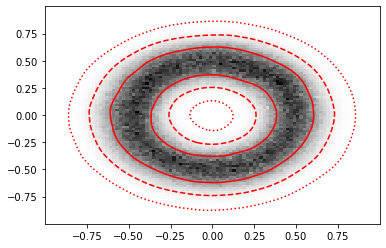

In [47]:
swyft.plot_2d(predictions, "z[0]", "z[1]", bins = 100, smooth = 2, color = 'r', ax = plt.gca(), cmap = 'gray_r');

In [49]:
mass = trainer.estimate_mass(network, samples[:100], B[:2000])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting:  11%|█▏        | 912/8000 [00:06<01:34, 75.37it/s] 
Predicting: 389it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 389it [00:01, ?it/s]


In [56]:
trainer.hpd_coverage

AttributeError: 'SwyftTrainer' object has no attribute 'hpd_coverage'

In [52]:
def plot_z_score(masses, params, axes = None):
    axes = axes if axes is not None else plt.gca()
    params = params if isinstance(params, list) else [params]
    scores = None
    if isinstance(masses, list) or isinstance(masses, tuple):
        for i in range(len(masses)):
            scores = masses[i].get_matching_z_score(*params)
            if scores is not None:
                break
    if scores is not None:
        swyft.plot.mass.plot_empirical_z_score(axes, scores[:,0], scores[:,1], scores[:,2:])

In [53]:
def plot_scores(mass):
    s = mass.get_z_scores()
    for j, k in enumerate(s.keys()):
        for i in [0, 1, 2]:
            y = s[k][i,1]
            yerr = np.array([s[k][i,2]-y, y-s[k][i,0]]).reshape(2, 1)
            plt.errorbar(j, [y], yerr = yerr, marker='.', color='k')
    labels = [list(v) for v in s.keys()]
    plt.xticks(range(len(labels)), labels)
    plt.axhline(1., color='k', ls=':')
    plt.axhline(2., color='k', ls=':')
    plt.axhline(3., color='k', ls=':')

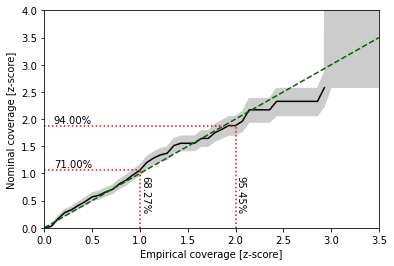

In [54]:
plot_z_score(mass, ["z[0]", "z[1]"])

<ipython-input-53-0df9aa5c6d74>:6: RuntimeWarning: invalid value encountered in double_scalars
  yerr = np.array([s[k][i,2]-y, y-s[k][i,0]]).reshape(2, 1)
<ipython-input-53-0df9aa5c6d74>:6: RuntimeWarning: invalid value encountered in double_scalars
  yerr = np.array([s[k][i,2]-y, y-s[k][i,0]]).reshape(2, 1)
<ipython-input-53-0df9aa5c6d74>:6: RuntimeWarning: invalid value encountered in double_scalars
  yerr = np.array([s[k][i,2]-y, y-s[k][i,0]]).reshape(2, 1)


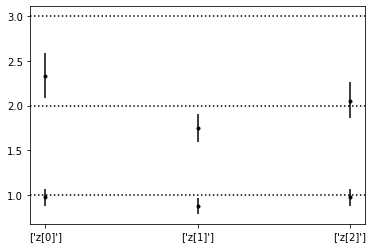

In [55]:
plot_scores(mass[0])